In [1]:
import os
import json
from tqdm import tqdm_notebook
import time
import numpy as np
import scipy
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
# Для обработки текстов
import pymorphy2

In [1]:
# Для работы с нейросетями
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

Загрузите данные

Создайте папку и положите в неё данные (avito_train.csv и avito_category.csv). Путь к папке назвать DIR_PATH

In [5]:
DIR_PATH = '/Users/anastasiatolstun/Desktop/machine/data4'

In [6]:
dat = pd.read_csv(os.path.join(DIR_PATH, 'avito.csv'))
cat_descr = pd.read_csv(os.path.join(DIR_PATH, 'avito_category.csv'))

In [7]:
cat_descr = pd.read_csv(os.path.join(DIR_PATH,'avito_category.csv'))
dat['category_name'] = dat.category_id.map(dict(zip(cat_descr.category_id, cat_descr.name)))

In [8]:
dat.head()

,item_id,title,description,price,category_id,category_name
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,Для дома и дачи|Мебель и интерьер|Предметы инт...
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,Для дома и дачи|Мебель и интерьер|Столы и стулья
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,Личные вещи|Красота и здоровье|Приборы и аксес...
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,Хобби и отдых|Книги и журналы|Книги
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,Бытовая электроника|Ноутбуки


In [9]:
len(np.unique(dat.category_name))
      

54

In [10]:
np.unique(dat.category_name)

array(['Бытовая электроника|Аудио и видео|Акустика, колонки, сабвуферы',
       'Бытовая электроника|Аудио и видео|Телевизоры и проекторы',
       'Бытовая электроника|Игры, приставки и программы|Игровые приставки',
       'Бытовая электроника|Игры, приставки и программы|Игры для приставок',
       'Бытовая электроника|Настольные компьютеры',
       'Бытовая электроника|Ноутбуки',
       'Бытовая электроника|Планшеты и электронные книги|Планшеты',
       'Бытовая электроника|Телефоны|Nokia',
       'Бытовая электроника|Телефоны|Samsung',
       'Бытовая электроника|Телефоны|Sony',
       'Бытовая электроника|Телефоны|iPhone',
       'Бытовая электроника|Телефоны|Аксессуары|Чехлы и плёнки',
       'Бытовая электроника|Телефоны|Другие марки',
       'Бытовая электроника|Товары для компьютера|Мониторы',
       'Бытовая электроника|Товары для компьютера|Сетевое оборудование',
       'Для дома и дачи|Бытовая техника|Для дома|Стиральные машины',
       'Для дома и дачи|Бытовая техника|Для ку

### Задание 1
### Подготовка данных

[1.1] (0.5 балла)

Разбейте таргет на иерархические классы.

In [11]:
data= dat['category_name'].str.split(pat = "|", n = 4,expand = True)
data

,0,1,2,3
0,Для дома и дачи,Мебель и интерьер,"Предметы интерьера, искусство",None
1,Для дома и дачи,Мебель и интерьер,Столы и стулья,None
2,Личные вещи,Красота и здоровье,Приборы и аксессуары,None
3,Хобби и отдых,Книги и журналы,Книги,None
4,Бытовая электроника,Ноутбуки,None,None
5,Хобби и отдых,Музыкальные инструменты,Гитары и другие струнные,None
6,Личные вещи,Товары для детей и игрушки,Товары для кормления,None
7,Личные вещи,Часы и украшения,Часы,None
8,Хобби и отдых,Билеты и путешествия,Путешествия,None
9,Для дома и дачи,Мебель и интерьер,"Предметы интерьера, искусство",None


In [12]:
# Ваш код здесь:
dat['category_1'] = data[0]
dat['category_2'] = data[1]
dat['category_3'] = data[2]
dat['category_4'] = data[3]

In [13]:
dat

,item_id,title,description,price,category_id,category_name,category_1,category_2,category_3,category_4
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,Для дома и дачи|Мебель и интерьер|Предметы инт...,Для дома и дачи,Мебель и интерьер,"Предметы интерьера, искусство",None
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,Для дома и дачи|Мебель и интерьер|Столы и стулья,Для дома и дачи,Мебель и интерьер,Столы и стулья,None
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,Личные вещи|Красота и здоровье|Приборы и аксес...,Личные вещи,Красота и здоровье,Приборы и аксессуары,None
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,Хобби и отдых|Книги и журналы|Книги,Хобби и отдых,Книги и журналы,Книги,None
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,Бытовая электроника|Ноутбуки,Бытовая электроника,Ноутбуки,None,None
5,5,Бас гитара invasion bg110,Состояние хорошее. Имеется теплый чехол .,3999.0,50,Хобби и отдых|Музыкальные инструменты|Гитары и...,Хобби и отдых,Музыкальные инструменты,Гитары и другие струнные,None
6,6,"Смесь ""Грудничок"" г. Зеленодольск",Смесь молочная адаптированная ультрапастеризов...,15.0,41,Личные вещи|Товары для детей и игрушки|Товары ...,Личные вещи,Товары для детей и игрушки,Товары для кормления,None
7,7,G-shock,Часы абсолютно новые! с коробкой. Часы Китай...,2500.0,36,Личные вещи|Часы и украшения|Часы,Личные вещи,Часы и украшения,Часы,None
8,8,"Санатории Белоруссии. - ""Лепельский военный""",Санатории Белоруссии! - «Лепельский военный» ...,1090.0,48,Хобби и отдых|Билеты и путешествия|Путешествия,Хобби и отдых,Билеты и путешествия,Путешествия,None
9,9,Фотохолст,Фотохолст на подрамнике. 36х58см. Галерейная н...,1250.0,19,Для дома и дачи|Мебель и интерьер|Предметы инт...,Для дома и дачи,Мебель и интерьер,"Предметы интерьера, искусство",None


Загрузите список стоп-слов https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.json

In [100]:
import json

In [151]:
stop_words_set = set(json.load(open(os.path.join(DIR_PATH, 'stopwords-ru.json'), mode='r', encoding='utf-8')))
stop_words_lemm_set = set()

In [152]:
for word in stop_words_set:
    lemm_word = morph.parse(word)[0].normal_form
    if lemm_word not in stop_words_lemm_set:
        stop_words_lemm_set = stop_words_lemm_set.union([lemm_word])
if "дом" in stop_words_lemm_set:
    stop_words_lemm_set = stop_words_lemm_set.difference(['дом'])
if "книга" in stop_words_lemm_set:
    stop_words_lemm_set = stop_words_lemm_set.difference(['книга'])
if "другой" in stop_words_lemm_set:
    stop_words_lemm_set = stop_words_lemm_set.difference(['другой'])
if "дверь" in stop_words_lemm_set:
    stop_words_lemm_set = stop_words_lemm_set.difference(['дверь'])

In [116]:
stop_words_lemm_set

{'c',
 'а',
 'алло',
 'без',
 'белый',
 'близко',
 'более',
 'большой',
 'будто',
 'бы',
 'бывать',
 'бывь',
 'быть',
 'в',
 'важный',
 'ваш',
 'вверх',
 'вдали',
 'вдруг',
 'ведь',
 'везде',
 'вернуться',
 'вес',
 'весь',
 'вечер',
 'взгляд',
 'взять',
 'вид',
 'видеть',
 'вместе',
 'вне',
 'вниз',
 'внизу',
 'вод',
 'война',
 'вокруг',
 'вон',
 'вообще',
 'вопрос',
 'восемнадцать',
 'восемь',
 'вот',
 'впрочем',
 'время',
 'все ещё',
 'всегда',
 'всего',
 'всеять',
 'всюду',
 'вы',
 'выгодно',
 'выйти',
 'где',
 'главный',
 'глаз',
 'говорить',
 'год',
 'голова',
 'голос',
 'город',
 'да',
 'давать',
 'давно',
 'даже',
 'далеко',
 'далёкий',
 'даром',
 'дать',
 'два',
 'двадцать',
 'двенадцать',
 'девятнадцать',
 'девять',
 'действительно',
 'делать',
 'дело',
 'день',
 'деньга',
 'десять',
 'для',
 'до',
 'довольно',
 'долго',
 'должный',
 'дорога',
 'доставка',
 'друг',
 'друго',
 'думать',
 'душить',
 'е',
 'если',
 'есть',
 'ещё',
 'её',
 'ж',
 'ждать',
 'же',
 'жена',
 'женщина'

[1.2] (1 балл)

Лемматизируйте категории (таргеты)

In [17]:
from joblib import Parallel, delayed
import multiprocessing
import re
cores = multiprocessing.cpu_count()
morph = pymorphy2.MorphAnalyzer()

In [121]:
def preprocessing(msg):
    if type(msg) == str or word not in stop_words_lemm_set:
        msg = re.findall(r'[a-zA-Zа-яА-ЯёЁ]+', msg.lower()) 
        msg = [morph.parse(word)[0].normal_form for word in msg]
        return msg
    else:
        return None

In [118]:
print(preprocessing(dat.category_1[0]))

None


In [122]:
# Ваш код здесь:
dat['category_1_prep'] = Parallel(n_jobs=cores-2)(delayed(preprocessing)(doc) for doc in tqdm_notebook(dat.category_1)) 

In [123]:
dat.category_1_prep

0            [для, дом, и, дача]
1            [для, дом, и, дача]
2                [личный, вещий]
3              [хобби, и, отдых]
4         [бытовой, электроника]
5              [хобби, и, отдых]
6                [личный, вещий]
7                [личный, вещий]
8              [хобби, и, отдых]
9            [для, дом, и, дача]
10               [личный, вещий]
11               [личный, вещий]
12               [личный, вещий]
13             [хобби, и, отдых]
14           [для, дом, и, дача]
15           [для, дом, и, дача]
16           [для, дом, и, дача]
17           [для, дом, и, дача]
18               [личный, вещий]
19               [личный, вещий]
20           [для, дом, и, дача]
21             [хобби, и, отдых]
22               [личный, вещий]
23           [для, дом, и, дача]
24        [бытовой, электроника]
25        [бытовой, электроника]
26        [бытовой, электроника]
27        [бытовой, электроника]
28               [личный, вещий]
29           [для, дом, и, дача]
          

In [126]:
dat['category_2_prep'] = Parallel(n_jobs=cores-2)(delayed(preprocessing)(doc) for doc in tqdm_notebook(dat.category_2)) 

In [23]:
len(dat['category_3'])

489517

In [127]:
dat['category_3_prep'] = Parallel(n_jobs=cores-2)(delayed(preprocessing)(doc) for doc in tqdm_notebook(dat.category_3)) 


In [128]:
dat['category_4_prep'] = Parallel(n_jobs=cores-2)(delayed(preprocessing)(doc) for doc in tqdm_notebook(dat.category_4)) 

[1.3] (2 балла)

Лемматизируйте заголовки и описания объявлений

In [129]:
# Ваш код здесь:
dat['title_prep'] = Parallel(n_jobs=cores-2)(delayed(preprocessing)(doc) for doc in tqdm_notebook(dat.title)) 

In [130]:
dat['description_prep'] = Parallel(n_jobs=cores-2)(delayed(preprocessing)(doc) for doc in tqdm_notebook(dat.description)) 

In [131]:
dat

,item_id,title,description,price,category_id,category_name,category_1,category_2,category_3,category_4,category_1_prep,category_2_prep,category_3_prep,category_4_prep,title_prep,title_description,description_prep,title_description_prep
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,Для дома и дачи|Мебель и интерьер|Предметы инт...,Для дома и дачи,Мебель и интерьер,"Предметы интерьера, искусство",None,"[для, дом, и, дача]","[мебель, и, интерьер]","[предмет, интерьер, искусство]",None,[картина],Картина Гобелен. Размеры 139х84см.,"[гобелен, размер, х, сантиметр]","[картина, гобелен, размер, х, сантиметр]"
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,Для дома и дачи|Мебель и интерьер|Столы и стулья,Для дома и дачи,Мебель и интерьер,Столы и стулья,None,"[для, дом, и, дача]","[мебель, и, интерьер]","[стол, и, стул]",None,"[стул, из, прессовать, кожа]",Стулья из прессованной кожи Продам недорого 4 ...,"[продать, недорого, стул, из, светлый, прессов...","[стул, из, прессовать, кожа, продать, недорого..."
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,Личные вещи|Красота и здоровье|Приборы и аксес...,Личные вещи,Красота и здоровье,Приборы и аксессуары,None,"[личный, вещий]","[красота, и, здоровье]","[прибор, и, аксессуар]",None,"[домашний, минь, баня]","Домашняя мини баня Мини баня МБ-1(мини сауна),...","[минь, баня, мб, минь, сауна, предназначить, д...","[домашний, минь, баня, минь, баня, мб, минь, с..."
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,Хобби и отдых|Книги и журналы|Книги,Хобби и отдых,Книги и журналы,Книги,None,"[хобби, и, отдых]","[книга, и, журнал]",[книга],None,"[эксклюзивный, коллекция, книга, трансаэро, по...","Эксклюзивная коллекция книг ""Трансаэро"" + пода...","[продать, эксклюзивный, коллекция, книга, выпу...","[эксклюзивный, коллекция, книга, трансаэро, по..."
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,Бытовая электроника|Ноутбуки,Бытовая электроника,Ноутбуки,None,None,"[бытовой, электроника]",[ноутбук],None,None,"[ноутбук, aser]",Ноутбук aser Продаётся ноутбук ACER e5-511C2TA...,"[продаваться, ноутбук, acer, e, c, ta, купить,...","[ноутбук, aser, продаваться, ноутбук, acer, e,..."
5,5,Бас гитара invasion bg110,Состояние хорошее. Имеется теплый чехол .,3999.0,50,Хобби и отдых|Музыкальные инструменты|Гитары и...,Хобби и отдых,Музыкальные инструменты,Гитары и другие струнные,None,"[хобби, и, отдых]","[музыкальный, инструмент]","[гитара, и, другой, струнный]",None,"[бас, гитара, invasion, bg]",Бас гитара invasion bg110 Состояние хорошее. И...,"[состояние, хороший, иметься, тёплый, чехол]","[бас, гитара, invasion, bg, состояние, хороший..."
6,6,"Смесь ""Грудничок"" г. Зеленодольск",Смесь молочная адаптированная ультрапастеризов...,15.0,41,Личные вещи|Товары для детей и игрушки|Товары ...,Личные вещи,Товары для детей и игрушки,Товары для кормления,None,"[личный, вещий]","[товар, для, ребёнок, и, игрушка]","[товар, для, кормление]",None,"[смесь, грудничок, год, зеленодольск]","Смесь ""Грудничок"" г. Зеленодольск Смесь молочн...","[смесь, молочный, адаптировать, ультрапастериз...","[смесь, грудничок, год, зеленодольск, смесь, м..."
7,7,G-shock,Часы абсолютно новые! с коробкой. Часы Китай...,2500.0,36,Личные вещи|Часы и украшения|Часы,Личные вещи,Часы и украшения,Часы,None,"[личный, вещий]","[часы, и, украшение]",[часы],None,"[g, shock]",G-shock Часы абсолютно новые! с коробкой. Часы...,"[часы, абсолютно, новое, с, коробка, часы, кит...","[g, shock, часы, абсолютно, новое, с, коробка,..."
8,8,"Санатории Белоруссии. - ""Лепельский военный""",Санатории Белоруссии! - «Лепельский военный» ...,1090.0,48,Хобби и отдых|Билеты и путешествия|Путешествия,Хобби и отдых,Билеты и путешествия,Путешествия,None,"[хобби, и, отдых]","[билет, и, путешествие]",[путешествие],None,"[санаторий, белоруссия, лепельский, военный]","Санатории Белоруссии

[1.4] (0.5 балла)

Разбейте данные на обучение, валидацию и отложенный тест в пропорции 60/30/10. Постройте распределений категорий в каждом из разбиений для того, чтобы убедиться, что распределения совпадают

In [135]:
from sklearn.model_selection import train_test_split

In [136]:
# Ваш код здесь:
np.random.seed(10) # Не меняем random seed!
tr_indexes, val_indexes, te_indexes = np.split(
    np.random.permutation(np.arange(489517)), [int(489517*0.6), int(489517*0.9)]
)

In [137]:
print("Обучающая выборка", len(tr_indexes))
print("Валидационная выборка", len(val_indexes))
print("Отложенная выборка", len(te_indexes))

Обучающая выборка 293710
Валидационная выборка 146855
Отложенная выборка 48952


In [ ]:
# Здесь постройте распределения:

In [44]:
np.unique(dat.category_1_prep[tr_indexes], return_counts=True)

(array([list(['бытовой', 'электроника']),
        list(['для', 'дом', 'и', 'дача']), list(['личный', 'вещий']),
        list(['хобби', 'и', 'отдых'])], dtype=object),
 array([78912, 83539, 64509, 66750]))

In [48]:
x = [78912, 83539, 64509, 66750]

In [138]:
dat.category_3_prep = dat.category_3_prep.replace([None], [''], regex=True)

In [140]:
dat.category_4_prep = dat.category_4_prep.replace([None], [''], regex=True)

In [141]:
dat.category_4_prep

0                           
1                           
2                           
3                           
4                           
5                           
6                           
7                           
8                           
9                           
10                   [обувь]
11                          
12                          
13                          
14                          
15                          
16                          
17                          
18                          
19                  [другой]
20                          
21                          
22                          
23                          
24                          
25                          
26                          
27                          
28         [верхний, одежда]
29                          
                 ...        
489487                      
489488                      
489489                      
489490    [чех

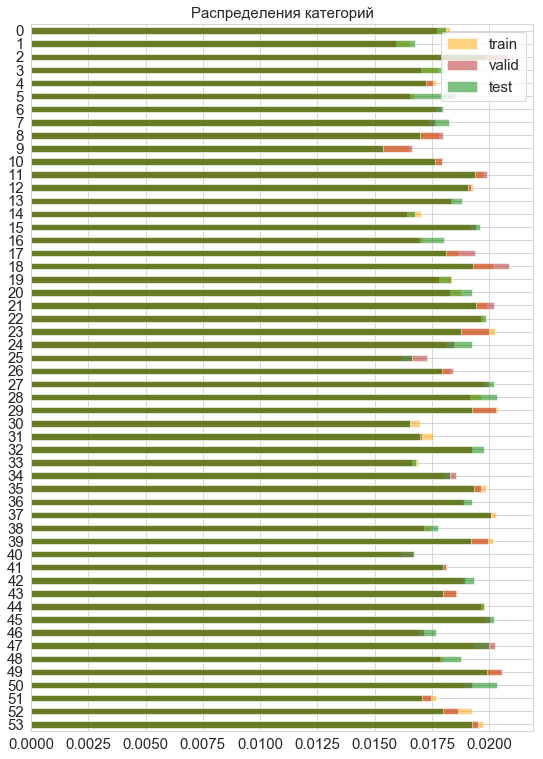

In [145]:
plt.figure(figsize=(9, 13))
plt.title('Распределения категорий', fontsize=15);
dat.category_id[tr_indexes].value_counts(1).sort_index(ascending=False).plot(kind='barh', fontsize=15, color='orange', alpha=0.5, label='train');
dat.category_id[val_indexes].value_counts(1).sort_index(ascending=False).plot(kind='barh', fontsize=15, color='firebrick', alpha=0.5, label='valid');
dat.category_id[te_indexes].value_counts(1).sort_index(ascending=False).plot(kind='barh', fontsize=15, color='green', alpha=0.5, label='test');
plt.legend(fontsize=15);

### Задание 2
### Бейзлайн

[2.1] (5 баллов)

Обучите простую модель для того, чтобы в дальнейшем с ней сравниваться. Точность (accuracy) данной бейзлан модели должна быть > 0.6. 

В качестве такой модели можно взять Tf-Idf преобразования текстов + (logreg/random forest/boosting/...). Можно так же попробовать в качестве признаков взять word2vec вектора слов.

In [149]:
type(dat.description_prep)

pandas.core.series.Series

In [155]:
dat.description_prep

0                           [гобелен, размер, х, сантиметр]
1         [продать, недорого, стул, из, светлый, прессов...
2         [минь, баня, мб, минь, сауна, предназначить, д...
3         [продать, эксклюзивный, коллекция, книга, выпу...
4         [продаваться, ноутбук, acer, e, c, ta, купить,...
5              [состояние, хороший, иметься, тёплый, чехол]
6         [смесь, молочный, адаптировать, ультрапастериз...
7         [часы, абсолютно, новое, с, коробка, часы, кит...
8         [санаторий, белоруссия, лепельский, военный, ц...
9         [фотохолст, на, подрамник, х, сантиметр, галер...
10        [в, хороший, состояние, тёмный, коричневый, цв...
11        [игрушка, playgro, б, у, состояние, отличный, ...
12        [кроватка, для, новорождённый, регулироваться,...
13        [продать, утяжелитель, поясной, новое, килогра...
14                [продать, люстра, в, отличный, состояние]
15        [семя, фацелия, отличный, медонос, нетребовате...
16        [в, хороший, состояние, с, пол

In [161]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tf_idf = TfidfVectorizer(min_df=20, max_df=0.90)
# cou = CountVectorizer(min_df=20, max_df=0.90)
tf_idf.fit(dat.description_prep.str.join(''))
# cou.fit(dat.description_processed)

CPU times: user 7.28 s, sys: 2.59 s, total: 9.86 s
Wall time: 10.4 s


In [162]:
word_idf_dict = dict(sorted(dict(zip(tf_idf.get_feature_names(), tf_idf.idf_)).items(), key=lambda x: x[1], reverse=False))

In [168]:
dat['description_prep1'] = dat.description_prep.str.join('')

In [171]:
import gensim

In [175]:
%%time
w2v_fpath = os.path.join(DIR_PATH, 'all.norm-sz100-w10-cb0-it1-min100.w2v')
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_fpath, binary=True, unicode_errors='ignore')
w2v.init_sims(replace=True)

CPU times: user 45.3 s, sys: 42.5 s, total: 1min 27s
Wall time: 1min 38s


In [180]:
titles_w2v = np.zeros((dat.shape[0], 100))
descr_w2v = np.zeros((dat.shape[0], 100))
cat_w2v = np.zeros((dat.category_1_prep.value_counts().shape[0], 100))
category_names_order = dat.category_1_prep.value_counts().keys().values
for i in tqdm_notebook(range(dat.shape[0])):
    title = str(dat.title_prep[i]).split()
    descr = str(dat.description_prep[i]).split()
    
    denominator = np.array([word_idf_dict.get(word, 0) for word in title])
    numerator = np.array([w2v[word]*word_idf_dict.get(word, 0) if word in w2v else np.zeros((100,)).astype(float) for word in title])
    titles_w2v[i] = numerator.sum(axis=0)/(denominator.sum() + 1e-120)
    
    denominator = np.array([word_idf_dict.get(word, 0) for word in descr])
    numerator = np.array([w2v[word]*word_idf_dict.get(word, 0) if word in w2v else np.zeros((100,)).astype(float) for word in descr])
    descr_w2v[i] = numerator.sum(axis=0)/(denominator.sum() + 1e-120)
    
for n, categ in enumerate(category_names_order):
    denominator = np.array([word_idf_dict.get(word, 0) for word in str(categ).split()])
    numerator = np.array([w2v[word]*word_idf_dict.get(word, 0) if word in w2v else np.zeros((100,)).astype(float) for word in str(categ).split()])
    cat_w2v[n] = numerator.sum(axis=0)/(denominator.sum() + 1e-120)

/Users/anastasiatolstun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


ValueError: could not broadcast input array from shape (100) into shape (500)

In [ ]:
%%time
title_cat_dist = scipy.spatial.distance.cdist(titles_w2v, cat_w2v, metric='cosine')
title_descr_dist = []
for i in tqdm_notebook(range(len(dat))):
    dis = scipy.spatial.distance.cosine(titles_w2v[i].astype(float), descr_w2v[i].astype(float))
    if not np.isnan(dis):
        title_descr_dist.append(dis)
    else:
        title_descr_dist.append(-9999.0)
descr_cat_dist = scipy.spatial.distance.cdist(descr_w2v, cat_w2v, metric='cosine')

In [ ]:
X = np.hstack((title_cat_dist, np.array(title_descr_dist).reshape(-1, 1), descr_cat_dist))
y = dat.category_id.values
tr_nonnull = tr_indexes[~np.isnan(X[tr_indexes].sum(axis=1))]
te_nonnull = te_indexes[~np.isnan(X[te_indexes].sum(axis=1))]
valid_nonnull = valid_indexes[~np.isnan(X[valid_indexes].sum(axis=1))]
X_tr = X[tr_nonnull]
y_tr = y[tr_nonnull]
X_te = X[np.union1d(te_nonnull, valid_nonnull)]
y_te = y[np.union1d(te_nonnull, valid_nonnull)]
X_valid = X[valid_nonnull]
y_valid = y[valid_nonnull]

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
%%time
model = LogisticRegression(C=5, multi_class='auto')
model.fit(X_tr, y_tr)

In [ ]:
# Качество на отложенном тесте
accuracy_score(y_true=y_te, y_pred=model.predict(X_te))

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
%%time
model_lgb = LGBMClassifier(n_estimators=100)
model_lgb.fit(X_tr, y_tr)

In [ ]:
# Качество на отложенном тесте
accuracy_score(y_true=y_te, y_pred=model_lgb.predict(X_te))

## НЕ ДОУЧИЛА МОДЕЛЬ, РАБОТАТЬ ДОЛЖНА

[2.2] (2 балла)

Посчитайте качество вашей бейзлайн модели на отложенном тесте (te_indexe)

In [9]:
# Ваш код здесь:

### Задание 3

### Нейросетки

Настало время для действительно крутых моделей!

[3.1] (26 баллов) [Точность на тесте 0.6 - 0 баллов, точность на тесте 0.86 и более - 26 баллов]

Обучите нейросетку, которая бы решала данную задачу с точностью > 0.86. Вы неограничены в выборе архитектуры нейросети. Можно начать с Tf-Idf + полносвязная сеть. Экспериментируйте!

In [11]:
# Ваш код здесь: